In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn

In [49]:
def SphericalToCartesian(ele, azi, dist):
    phi = np.deg2rad(90-ele)
    theta = np.deg2rad(azi)
    
    x = dist * np.sin(phi) * np.cos(theta)
    #x=ρsinφcosθ 
    y = dist * np.sin(phi) * np.sin(theta)
    #y=ρsinφsinθ 
    z = dist * np.cos(phi)
    #z=ρcosφ
    return np.array([x, y, z])

def CartesianToSpherical(x, y, z):
    dist = np.sqrt(x*x + y*y + z*z)
    theta = np.arctan2(y,x)    
    phi = np.arccos(z/dist)
    ele = 90 - np.rad2deg(phi)
    azi = np.rad2deg(theta)
    return np.array([round(ele), round(azi), round(dist), theta])

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm


#Get all metadata

filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development

full_metadata = pd.DataFrame()
#all_metadata
max_it = 400
c = 0
for i in range(len(filenames_meta)):
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    coord = np.zeros((len(metadata),3))
    sphe = np.zeros((len(metadata),4))
    for index, row in metadata.iterrows():
        coord[index, :] = SphericalToCartesian(row['ele'], row['azi'], row['dist'])
        sphe[index, :] = CartesianToSpherical(coord[index, 0], coord[index, 1], coord[index, 2])
        if row['sound_event_recording'] == 'phone' and row['ele'] == -10 and row['azi'] == 110 and row['dist'] == 2:
            print(filenames_meta[i])
    metadata['x'] = coord[:,0]
    metadata['y'] = coord[:,1]
    metadata['z'] = coord[:,2]
    
    metadata['ele_r'] = sphe[:,0]
    metadata['azi_r'] = sphe[:,1]
    metadata['dist_r'] = sphe[:,2]
    metadata['theta'] = sphe[:,3]
    
    full_metadata = full_metadata.append(metadata, ignore_index=True, sort=False)
    c +=1
    if c == max_it:
        break
print(len(full_metadata))
print(len(full_metadata.loc[full_metadata['sound_event_recording'] == 'phone']))

split1_ir0_ov1_5.csv
split1_ir0_ov2_20.csv
split1_ir3_ov2_73.csv
split1_ir4_ov1_88.csv
split2_ir0_ov2_20.csv
split3_ir3_ov2_74.csv
split4_ir0_ov1_7.csv
15798
1421


In [50]:

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

# def extract_features_target(signal, location):
#     stft_amp = np.zeros((128,0))
#     stft_phase = np.zeros((128,0))
#     for i in range(4):
#         stft = librosa.stft(signal[i], n_fft=1024, hop_length=512)
#         stft_amp = np.append(stft_amp, lin_interp_2d(librosa.amplitude_to_db(np.abs(stft)), (128,64)), axis=1)
#         stft_phase = np.append(stft_phase, lin_interp_2d(np.angle(stft), (128,64)), axis = 1)

#         #print(stft_amp.shape)
#         #print(np.std(stft_amp[0]))


#     stft_amp = sklearn.preprocessing.scale(stft_amp, axis = 1)
#     stft_phase = sklearn.preprocessing.scale(stft_phase, axis = 1)

#     feature = np.append(stft_amp.flatten(), stft_phase.flatten())
#     return feature, np.array(location)

def extract_features_target(signal, location):
    stft_amp = np.zeros((128,0))
    stft_phase = np.zeros((128,0))
    for i in range(4):
        stft = librosa.stft(signal[i], n_fft=1024, hop_length=512)
        amp = lin_interp_2d(librosa.amplitude_to_db(np.abs(stft)), (128,64))
        phase = lin_interp_2d(np.angle(stft), (128,64))
        stft_amp = np.append(stft_amp, amp, axis=1)
        stft_phase = np.append(stft_phase, phase, axis = 1)

        #print(stft_amp.shape)
        #print(np.std(stft_amp[0]))


    #stft_amp = sklearn.preprocessing.scale(stft_amp, axis = 1)
    #stft_phase = sklearn.preprocessing.scale(stft_phase, axis = 1)
    
    stft_amp = sklearn.preprocessing.normalize(stft_amp, axis = 1)
    stft_phase = sklearn.preprocessing.normalize(stft_phase, axis = 1)

    feature = np.append(stft_amp.flatten(), stft_phase.flatten())
    #feature = sklearn.preprocessing.normalize(feature, axis = 1)
    return feature, np.array(location)

sr = 22050
filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development
features = np.zeros((len(full_metadata),65536)) #we compute the melspectrogram which once flattened will produce 22144 values
target = np.zeros((len(full_metadata),3)) #we store the 2 target values

example = 0
for i in range(max_it):
    
    #Metadata
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    filename = os.path.splitext(filenames_meta[i])[0]
    
    print("processing '" + filename + "' " + str(i + 1) + "/" + str(max_it))
    
    #Audio track
    signal, dummy = librosa.load('data/dcase_data/foa_dev/' + filename + '.wav', sr, mono=False)    
    
    for s in range(len(metadata)):
        if(metadata['sound_event_recording'][s] == 'phone' ):
            #print('processing',filenames[i])
            start_time = int(metadata['start_time'][s] * sr)
            end_time = int(metadata['end_time'][s] * sr)
            #print(str(end_time - start_time))
            subsignal = signal[:, start_time:end_time]
            #features[example,:], target[example,:] = extract_features_target(subsignal, metadata['x'][s],  metadata['y'][s], metadata['z'][s])
            features[example,:], target[example,:] = extract_features_target(subsignal, normalize(SphericalToCartesian(metadata['ele'][s],  metadata['azi'][s], metadata['dist'][s])))
            
            #Ipd.display(Ipd.Audio(subsignal, rate=sr))
            example += 1
print(features.shape)            
features = np.delete(features, np.arange(example,features.shape[0], 1, dtype=int), axis=0)
target = np.delete(target, np.arange(example,target.shape[0], 1, dtype=int), axis=0)
print('Done!')
print(features.shape)
print(example)

processing 'split1_ir0_ov1_1' 1/400
processing 'split1_ir0_ov1_10' 2/400
processing 'split1_ir0_ov1_2' 3/400
processing 'split1_ir0_ov1_3' 4/400
processing 'split1_ir0_ov1_4' 5/400
processing 'split1_ir0_ov1_5' 6/400
processing 'split1_ir0_ov1_6' 7/400
processing 'split1_ir0_ov1_7' 8/400
processing 'split1_ir0_ov1_8' 9/400
processing 'split1_ir0_ov1_9' 10/400
processing 'split1_ir0_ov2_11' 11/400
processing 'split1_ir0_ov2_12' 12/400
processing 'split1_ir0_ov2_13' 13/400
processing 'split1_ir0_ov2_14' 14/400
processing 'split1_ir0_ov2_15' 15/400
processing 'split1_ir0_ov2_16' 16/400
processing 'split1_ir0_ov2_17' 17/400
processing 'split1_ir0_ov2_18' 18/400
processing 'split1_ir0_ov2_19' 19/400
processing 'split1_ir0_ov2_20' 20/400
processing 'split1_ir1_ov1_21' 21/400
processing 'split1_ir1_ov1_22' 22/400
processing 'split1_ir1_ov1_23' 23/400
processing 'split1_ir1_ov1_24' 24/400
processing 'split1_ir1_ov1_25' 25/400
processing 'split1_ir1_ov1_26' 26/400
processing 'split1_ir1_ov1_27'

processing 'split3_ir0_ov2_15' 215/400
processing 'split3_ir0_ov2_16' 216/400
processing 'split3_ir0_ov2_17' 217/400
processing 'split3_ir0_ov2_18' 218/400
processing 'split3_ir0_ov2_19' 219/400
processing 'split3_ir0_ov2_20' 220/400
processing 'split3_ir1_ov1_21' 221/400
processing 'split3_ir1_ov1_22' 222/400
processing 'split3_ir1_ov1_23' 223/400
processing 'split3_ir1_ov1_24' 224/400
processing 'split3_ir1_ov1_25' 225/400
processing 'split3_ir1_ov1_26' 226/400
processing 'split3_ir1_ov1_27' 227/400
processing 'split3_ir1_ov1_28' 228/400
processing 'split3_ir1_ov1_29' 229/400
processing 'split3_ir1_ov1_30' 230/400
processing 'split3_ir1_ov2_31' 231/400
processing 'split3_ir1_ov2_32' 232/400
processing 'split3_ir1_ov2_33' 233/400
processing 'split3_ir1_ov2_34' 234/400
processing 'split3_ir1_ov2_35' 235/400
processing 'split3_ir1_ov2_36' 236/400
processing 'split3_ir1_ov2_37' 237/400
processing 'split3_ir1_ov2_38' 238/400
processing 'split3_ir1_ov2_39' 239/400
processing 'split3_ir1_ov

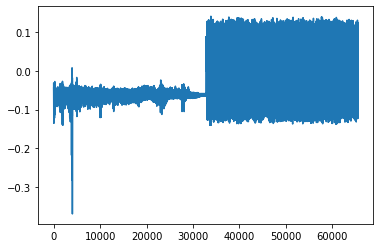

In [51]:
plt.plot(features[0])

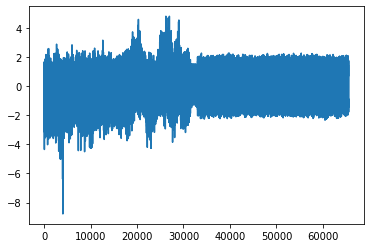

In [46]:
plt.plot(features[0])

In [6]:
#no we reload from file and re-extract the three separate arrays containing features, labels, and filenames
imported_dataset = pd.read_csv('dataset.csv')





NameError: name 'dataset' is not defined

In [8]:
#we stored 7 features when the data structure was empty, so they eneded in culumns 0 to 6 (included)
#iloc[:,0:6] means : ==> all rows, 0:7 ==> columns 0 to 6 (7 is not included)
imported_features = imported_dataset.iloc[:,0:65536].to_numpy()#we stored 7 features when the data structure was empty, so they eneded in culumns 0 to 6 
imported_labels = np.zeros((imported_features.shape[0],3))
imported_labels[:,0] = imported_dataset['x'] #we keep this as a pandas data structure, it will be handy to trace back misclassified files (because it's indexed)
imported_labels[:,1] = imported_dataset['y']
imported_labels[:,2] = imported_dataset['z']
features = imported_features
target = imported_labels

In [23]:
sr = 22050
melFreSize = 128
melTimeSamples = 1024

def getSpectrum(s):
    y = s[0:2048] * scipy.signal.blackmanharris(2048)
    X_amp = np.abs(np.fft.rfft(y))
    X_db = 20 * np.log10(X_amp)
    #freqs = np.fft.rfftfreq(2048, 1/sr)#this is not used
    return X_db
# def get_combine_feature(signal):
#     output = []
#     for i in range(signal.shape[0] - 1):
#         for j in range(i + 1, signal.shape[0]):
#             #print(i,"*" ,j)
#             #Lag calculation
#             cross = scipy.signal.correlate(signal[i], signal[j], mode ='full')
#             output.append(np.argmax(cross)-len(cross)/2)
#             #RMS Diference
#             rmsDiff = np.mean(librosa.feature.rms(signal[i])) - np.mean(librosa.feature.rms(signal[j]))
#             output.append(rmsDiff)
#     return output

def get_combine_feature(signal):
    output = []
    for i in range(signal.shape[0] - 1):
        for j in range(i + 1, signal.shape[0]):
            cross = scipy.signal.correlate(signal[i], signal[j], mode ='full')
            output.append(np.argmax(cross)-len(cross)/2)

    lag = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))
    
    output = []
    for i in range(signal.shape[0] - 1):
          for j in range(i + 1, signal.shape[0]):
            rmsDiff = np.mean(librosa.feature.rms(signal[i])) - np.mean(librosa.feature.rms(signal[j]))
            output.append(rmsDiff)

    rms = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))
    
    output = []        
    for i in range(signal.shape[0] - 1):
          for j in range(i + 1, signal.shape[0]):
            #RMS from spectrum Diference
            rmsDiff = np.mean(librosa.feature.rms(getSpectrum(signal[i]))) - np.mean(librosa.feature.rms(getSpectrum(signal[j])))
            output.append(rmsDiff)

    rms_spec = sklearn.preprocessing.normalize(np.array(output).reshape(1,-1))

    output = lag.flatten().tolist()
    output.extend(rms.flatten().tolist())
    #output = rms.flatten().tolist()
    output.extend(rms_spec.flatten().tolist())
    return output

def extract_features_target(signal, location):
    output_time = get_combine_feature(signal)   
        #for i in range(signal.shape[0]):
    #    output.extend([np.mean(signal[i]), np.var(signal[i])])
    return output_time, np.array(location)
#     output = librosa.feature.melspectrogram(signal[0], n_mels=15)
#     output = output.flatten()
    #output_time = get_lag_feature(signal)
    
    
#     melSig = np.zeros((4, melFreSize*melTimeSamples))
#     for i in range(signal.shape[0]):
#         melSpec = librosa.feature.melspectrogram(signal[i], n_mels=melFreSize)
#         #print(signal[i].shape, ", ", signal[i,:].shape)
        
        
#         melSpec = lin_interp_2d(melSpec, (melFreSize, melTimeSamples))
#         #showMel(melSpec)
#         melSig[i,:] = melSpec.flatten()
#     #output_freq = get_lag_feature(melSig)
#     output_mel = melSig.flatten()
    
    
#     #for i in range(signal.shape[0]):
#     #    output.extend([np.mean(signal[i]), np.var(signal[i])])
#     #output_time.extend(output_freq)
#     return output_mel, np.array(location)

#creating an array of zeros of the proper size where we will store computed features and lables

filenames_meta = os.listdir('data/dcase_data/metadata_dev') #Development
features = np.zeros((len(full_metadata),18)) #we compute the melspectrogram which once flattened will produce 22144 values
target = np.zeros((len(full_metadata),3)) #we store the 2 target values

example = 0
for i in range(max_it):
    
    #Metadata
    metadata = pd.read_csv('data/dcase_data/metadata_dev/' + filenames_meta[i])  #Development
    filename = os.path.splitext(filenames_meta[i])[0]
    
    print("processing '" + filename + "' " + str(i + 1) + "/" + str(max_it))
    
    #Audio track
    signal, dummy = librosa.load('data/dcase_data/foa_dev/' + filename + '.wav', sr, mono=False)    
    
    for s in range(len(metadata)):
        if(metadata['sound_event_recording'][s] == 'phone' ):
            #print('processing',filenames[i])
            start_time = int(metadata['start_time'][s] * sr)
            end_time = int(metadata['end_time'][s] * sr)
            #print(str(end_time - start_time))
            subsignal = signal[:, start_time:end_time]
            #features[example,:], target[example,:] = extract_features_target(subsignal, metadata['x'][s],  metadata['y'][s], metadata['z'][s])
            features[example,:], target[example,:] = extract_features_target(subsignal, normalize(SphericalToCartesian(metadata['ele'][s],  metadata['azi'][s], metadata['dist'][s])))
            
            #Ipd.display(Ipd.Audio(subsignal, rate=sr))
            example += 1
print(features.shape)            
features = np.delete(features, np.arange(example,features.shape[0], 1, dtype=int), axis=0)
target = np.delete(target, np.arange(example,target.shape[0], 1, dtype=int), axis=0)
print('Done!')
print(features.shape)
print(example)


processing 'split1_ir0_ov1_1' 1/400
processing 'split1_ir0_ov1_10' 2/400
processing 'split1_ir0_ov1_2' 3/400
processing 'split1_ir0_ov1_3' 4/400
processing 'split1_ir0_ov1_4' 5/400
processing 'split1_ir0_ov1_5' 6/400
processing 'split1_ir0_ov1_6' 7/400
processing 'split1_ir0_ov1_7' 8/400
processing 'split1_ir0_ov1_8' 9/400
processing 'split1_ir0_ov1_9' 10/400
processing 'split1_ir0_ov2_11' 11/400
processing 'split1_ir0_ov2_12' 12/400
processing 'split1_ir0_ov2_13' 13/400
processing 'split1_ir0_ov2_14' 14/400
processing 'split1_ir0_ov2_15' 15/400
processing 'split1_ir0_ov2_16' 16/400
processing 'split1_ir0_ov2_17' 17/400
processing 'split1_ir0_ov2_18' 18/400
processing 'split1_ir0_ov2_19' 19/400
processing 'split1_ir0_ov2_20' 20/400
processing 'split1_ir1_ov1_21' 21/400
processing 'split1_ir1_ov1_22' 22/400
processing 'split1_ir1_ov1_23' 23/400
processing 'split1_ir1_ov1_24' 24/400
processing 'split1_ir1_ov1_25' 25/400
processing 'split1_ir1_ov1_26' 26/400
processing 'split1_ir1_ov1_27'

processing 'split3_ir0_ov2_15' 215/400
processing 'split3_ir0_ov2_16' 216/400
processing 'split3_ir0_ov2_17' 217/400
processing 'split3_ir0_ov2_18' 218/400
processing 'split3_ir0_ov2_19' 219/400
processing 'split3_ir0_ov2_20' 220/400
processing 'split3_ir1_ov1_21' 221/400
processing 'split3_ir1_ov1_22' 222/400
processing 'split3_ir1_ov1_23' 223/400
processing 'split3_ir1_ov1_24' 224/400
processing 'split3_ir1_ov1_25' 225/400
processing 'split3_ir1_ov1_26' 226/400
processing 'split3_ir1_ov1_27' 227/400
processing 'split3_ir1_ov1_28' 228/400
processing 'split3_ir1_ov1_29' 229/400
processing 'split3_ir1_ov1_30' 230/400
processing 'split3_ir1_ov2_31' 231/400
processing 'split3_ir1_ov2_32' 232/400
processing 'split3_ir1_ov2_33' 233/400
processing 'split3_ir1_ov2_34' 234/400
processing 'split3_ir1_ov2_35' 235/400
processing 'split3_ir1_ov2_36' 236/400
processing 'split3_ir1_ov2_37' 237/400
processing 'split3_ir1_ov2_38' 238/400
processing 'split3_ir1_ov2_39' 239/400
processing 'split3_ir1_ov

In [24]:
print(features.shape)
print(target.shape)

(1421, 18)
(1421, 3)


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


#creating pipeline
#note that here we do not initialize the parameters we want to tune/change
#the parameters that we decide to initialize here will be fixed across the grid search
#we also need to keep track of the names (between the quotes)
#that we selected for the different components of the pipeline
#the names are needed when creating the grid of parameters

pipe = Pipeline([
        #('scaler', StandardScaler()),
        #('dim_red', PCA(n_components = 128)),
        ('classifier', MLPRegressor(max_iter=500, random_state = 1, activation='relu', alpha = 0.01))
        ])

#n_components = 10
#hidden_layer_sizes=(20,5), max_iter=10000, activation='relu'


#creating the repeated stratified k-folds
#this is not a must, we can do grid search with a simple k-fold
#cross validation by setting cv= to a number in the GridSearchCV constructor
rkf = RepeatedKFold(n_splits=5, n_repeats=10)


#defining the parameters range to explore
#the name of the parameters is preceeded by the name of the component
#in the pipeline followed by two underscore
#if you have trouble in identifying the correct, print all parameters and their
#names uwith the following commented line
#print(pipe.get_params().keys())
# grid_param = {
#     'dim_red__n_components': [16, 32, 64, 128],
#     #'classifier__hidden_layer_sizes': [(128, 128, 128), (81,27,9), (30,20,10), (500, 400, 300, 100, 50)],
#     'classifier__hidden_layer_sizes': [(256,128,64,32, 16, 8), (500, 400, 300, 100, 50)],
#     'classifier__activation': ['tanh', 'relu', 'logistic'],
#     'classifier__alpha': [0.01, 0.001],
# }

grid_param = {
    #'dim_red__n_components': [5, 8, 13, 21,34, 55, 89,144],
    #'dim_red__n_components': [21, 34, 55, 89,144],
    #'classifier__hidden_layer_sizes': [(10,9,8,7,6,5,4), (9,5,3), (13,8,5), (34,21)],#377
    'classifier__hidden_layer_sizes': [(9), (20), (18,9), (36, 18, 9)],#377
    #'classifier__hidden_layer_sizes': [(128, 128, 128), (81,27,9), (30,20,10), (500, 400, 300, 100, 50)],377
    #'classifier__hidden_layer_sizes': [(377, 233,144,89,55,34,21,13,8,5), (233,144,89,55,34,21,13,8,5)],
    'classifier__activation': ['logistic', 'relu', 'tanh'],
    'classifier__alpha': [0.1, 0.001],
}

gd_sr = GridSearchCV(estimator=pipe,
                     param_grid=grid_param,
                     scoring='r2', #this can be changes to accuracy, f1_micro, etc. or to another classification metric
                     cv=5, # if you do not want to do repeated kfold, you can set cv=5 to test just on 5 different splits 
                     n_jobs=-1, #if equal to -1 will use as many CPU as available
                     verbose = 4) 

gd_sr.fit(features, target) #performing the search

print('best set of parameters', gd_sr.best_params_)
print('associated best score',gd_sr.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 80.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 108.9min finished


best set of parameters {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': 9}
associated best score -0.0037211817582633844


In [18]:
gd_sr.predict()

make_scorer(r2_score)
